In [36]:
import numpy as np
import pandas as pd
from typing import List, Text, Optional

from rl4fisheries import Msy, ConstEsc, CautionaryRule, AsmEnv
from rl4fisheries.envs.asm_fns import get_r_devs

In [87]:
r_devs = get_r_devs(n_year=1000)
config = {"s":  0.97, "r_devs": r_devs}
env = AsmEnv(config = config)

In [88]:
def simulate_ep(env, agent, other_vars: Optional[List[Text]] = []):   
    simulation = {
        't': [],
        'surv_b_obs': [],
        'mean_wt_obs': [],
        'act': [],
        'rew': [],
        'total_pop': [],
        'newborns': [],
        'non_random_newb': [],
        **{var_name: [] for var_name in other_vars}
    }
    obs, _ = env.reset()
    for t in range(env.Tmax):
        act, _ = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(act)
        #
        simulation['t'].append(t)
        simulation['surv_b_obs'].append(
            env.bound * (obs[0]+1)/2
        )
        simulation['mean_wt_obs'].append(
            (
                env.parameters["min_wt"]
                + (env.parameters["max_wt"] - env.parameters["min_wt"])
                * (obs[1]+1)/2
            )
        )
        simulation['act'].append(act[0])
        simulation['rew'].append(rew)
        simulation['total_pop'].append(np.sum(env.state))
        simulation['newborns'].append(env.state[0])
        simulation['non_random_newb'].append(
            env.parameters["bha"] * env.ssb / (1 + env.parameters["bhb"] * env.ssb)
        )
        for var_name in other_vars:
            simulation[var_name].append(getattr(env, var_name))
        #
        obs = new_obs
    #
    return simulation

In [89]:
trivp = Msy(env = env, mortality=0)
trivial_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), trivp, other_vars=['ssb']))

<Axes: title={'center': 'newborns'}, xlabel='t'>

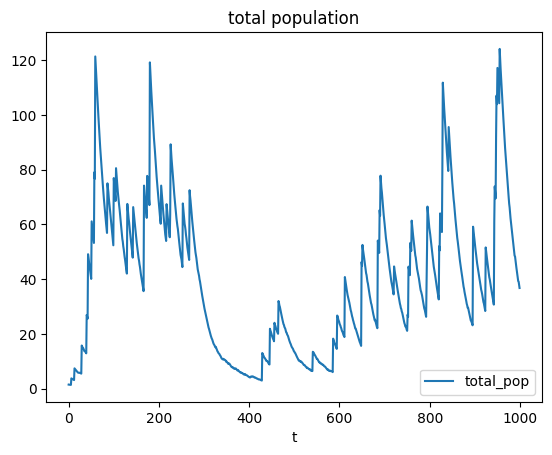

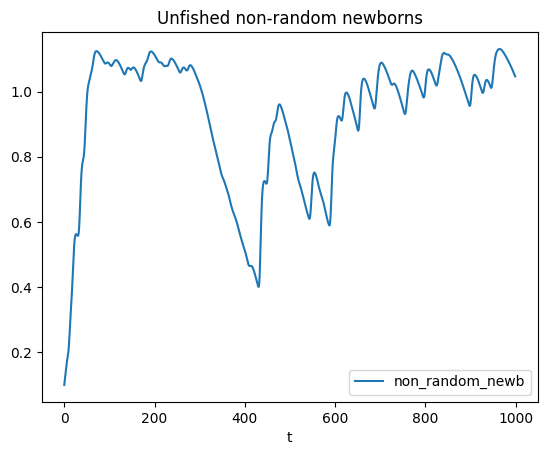

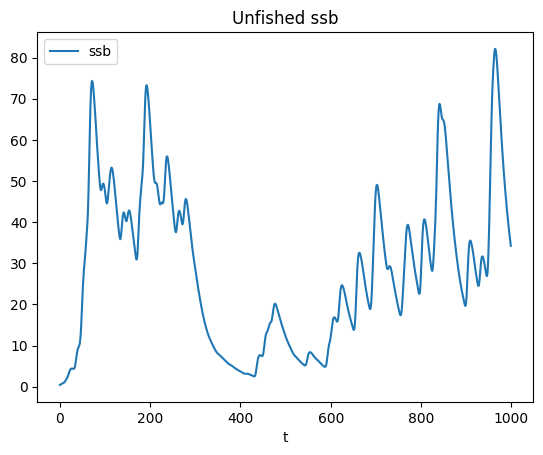

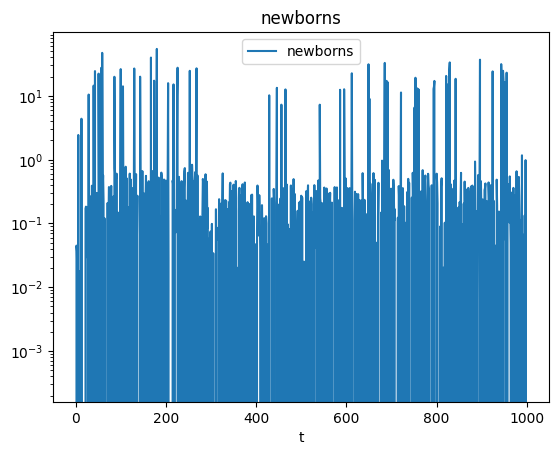

In [90]:
trivial_ep.plot(x='t', y = ['total_pop'], title='total population')
trivial_ep.plot(x='t', y = ['non_random_newb'], title='Unfished non-random newborns')
trivial_ep.plot(x='t', y = ['ssb'], title='Unfished ssb')
trivial_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True)

In [91]:
mid = Msy(env = env, mortality=0.05)
mid_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), mid, other_vars=['ssb']))

<Axes: title={'center': 'newborns'}, xlabel='t'>

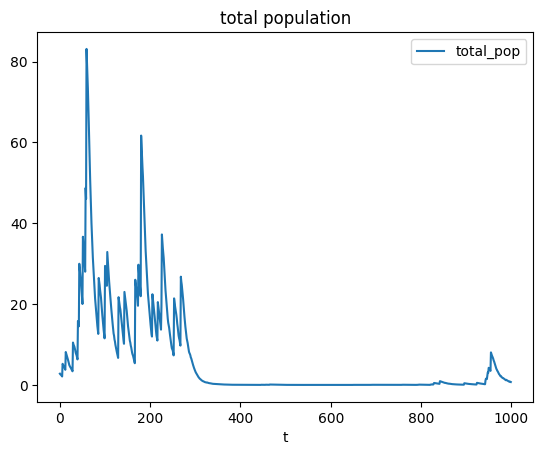

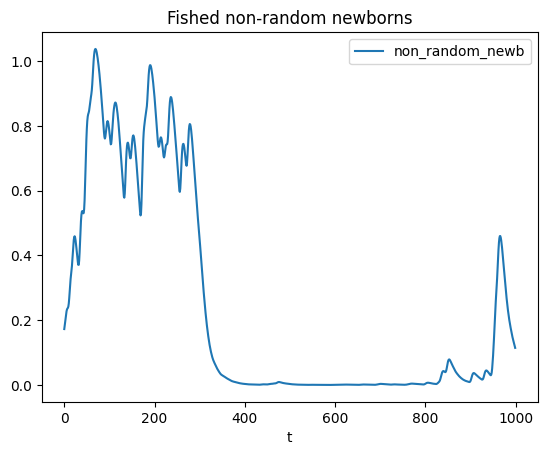

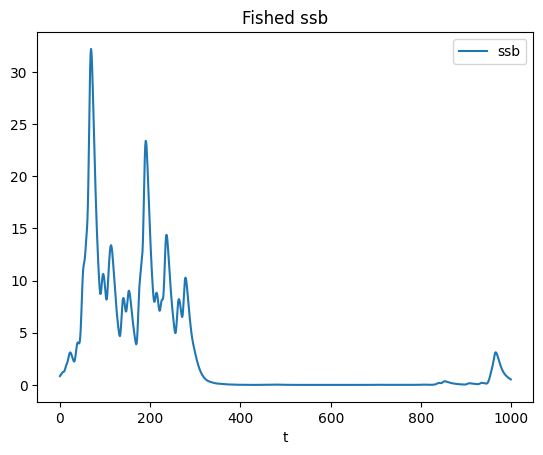

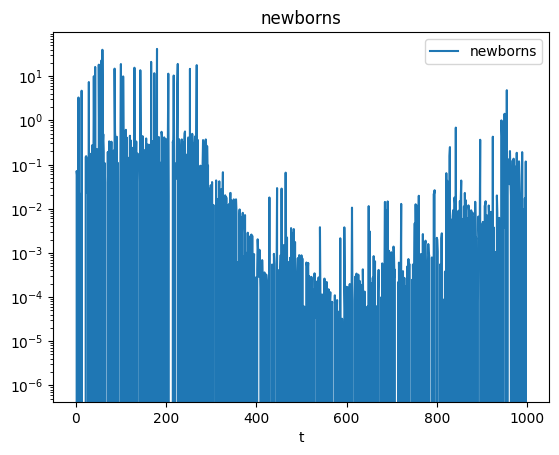

In [92]:
mid_ep.plot(x='t', y = ['total_pop'], title='total population')
mid_ep.plot(x='t', y = ['non_random_newb'], title='Fished non-random newborns')
mid_ep.plot(x='t', y = ['ssb'], title='Fished ssb')
mid_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True)

## Escapement

In [93]:
escp = ConstEsc(env, escapement = 0.0138)
esc_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), escp, other_vars=['ssb']))

<Axes: title={'center': 'newborns'}, xlabel='t'>

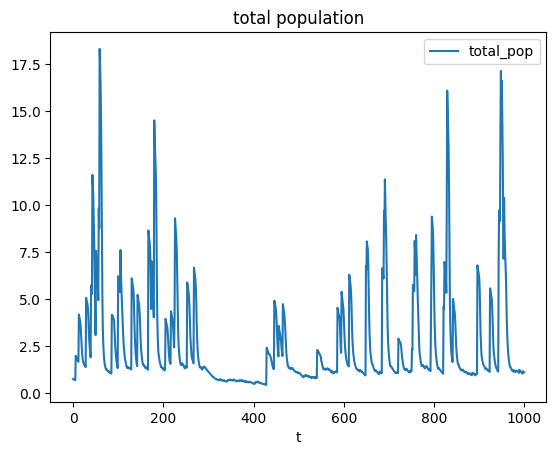

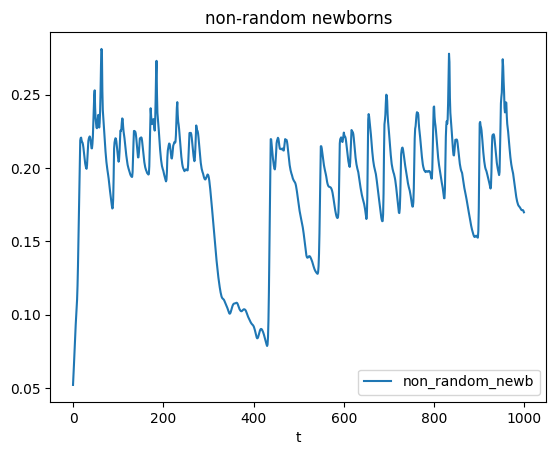

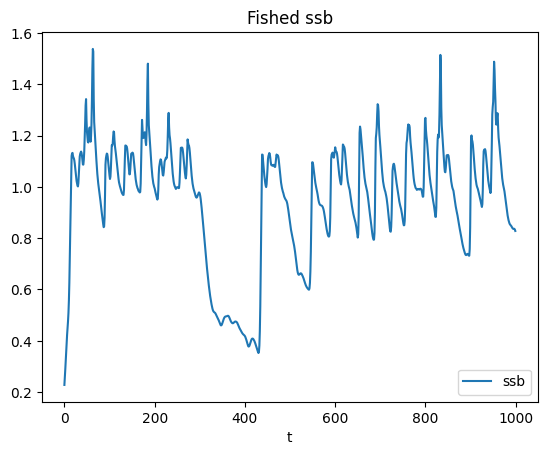

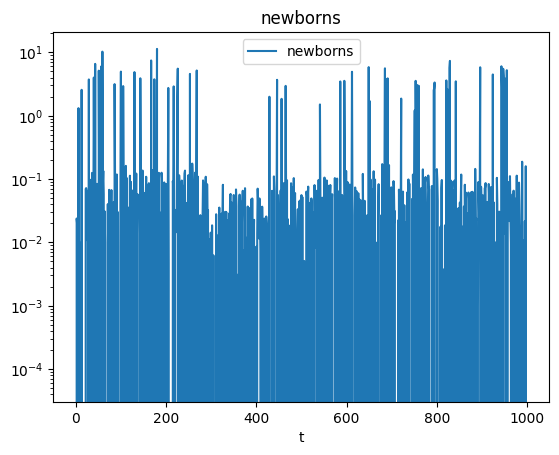

In [94]:
esc_ep.plot(x='t', y = ['total_pop'], title='total population')
esc_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns')
esc_ep.plot(x='t', y = ['ssb'], title='Fished ssb')
esc_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True)